In [38]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import boxcox

In [19]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [16]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [10]:
df_auto = pd.read_csv("monthly-us-auto-registration-tho.csv", sep=';')

In [11]:
df_auto.head()

,Month,Monthly U.S. auto registration (thousands) 1947 ? 1968
0,1947-01,209
1,1947-02,214
2,1947-03,265
3,1947-04,290
4,1947-05,287


In [13]:
df_auto.columns

Index(['Month', 'Monthly U.S. auto registration (thousands) 1947 ? 1968'], dtype='object')

In [14]:
auto_series = df_auto['Monthly U.S. auto registration (thousands) 1947 ? 1968']

Results of Dickey-Fuller Test:
Test Statistic                  -1.225039
p-value                          0.662733
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


/mnt/c/linux-venv/nlp/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


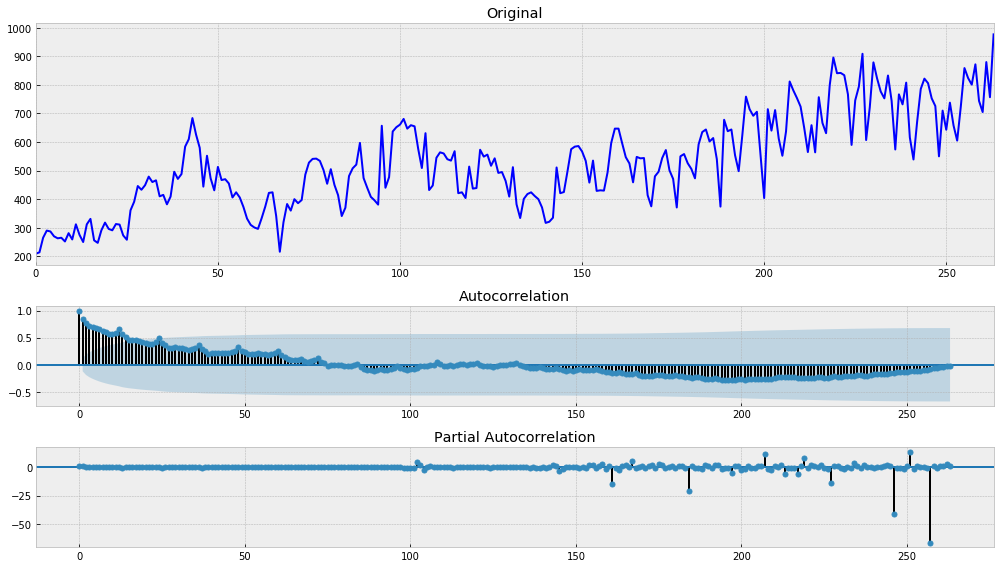

In [27]:
tsplot(auto_series)

Значение p-value (0.66) теста Дики-Фуллера не позволяет отвергнуть гипотезу о нестационарности ряда. Графики коррелограмм также не соответствуют стационарному ряду.

Пойдем стандартным маршрутом - применим преобразование Бокса-Кокса

Results of Dickey-Fuller Test:
Test Statistic                  -1.941628
p-value                          0.312738
#Lags Used                      14.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


/mnt/c/linux-venv/nlp/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


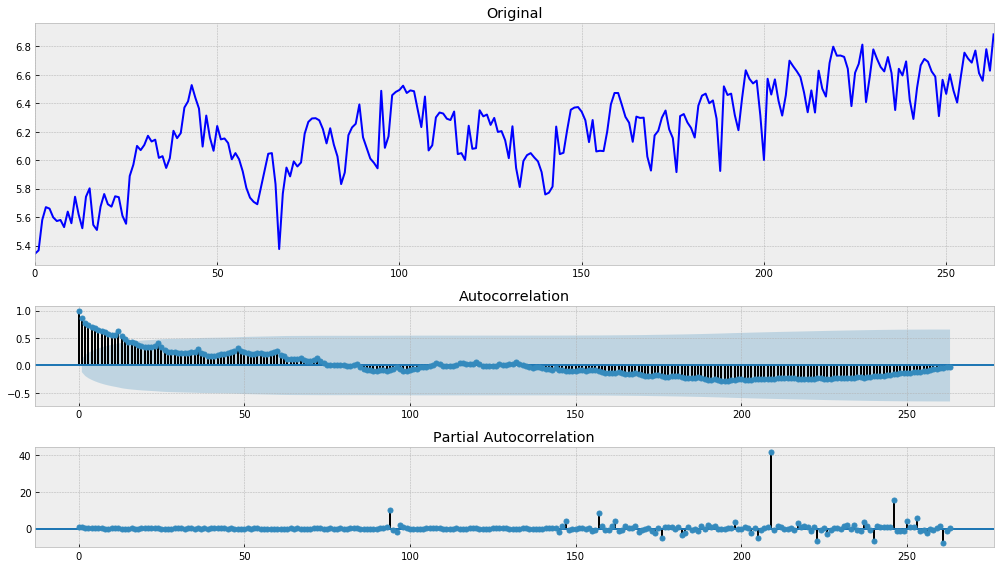

In [36]:
boxcox_auto_series = boxcox(auto_series, 0)
tsplot(boxcox_auto_series)

Преобразование Бокса-Кокса выравнило размах дисперсии. Наилучшее значеие p-value достигается при $\lambda$=0. Но, тем не менее, ни тест Дики-Фуллера, ни коррелограммы не позволяют признать ряд стационарным.

На графике хорошо видны тренд, сезонность и циклы. Пробуем продифференцировать ряд.

Results of Dickey-Fuller Test:
Test Statistic                  -4.362471
p-value                          0.000346
#Lags Used                      14.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


/mnt/c/linux-venv/nlp/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


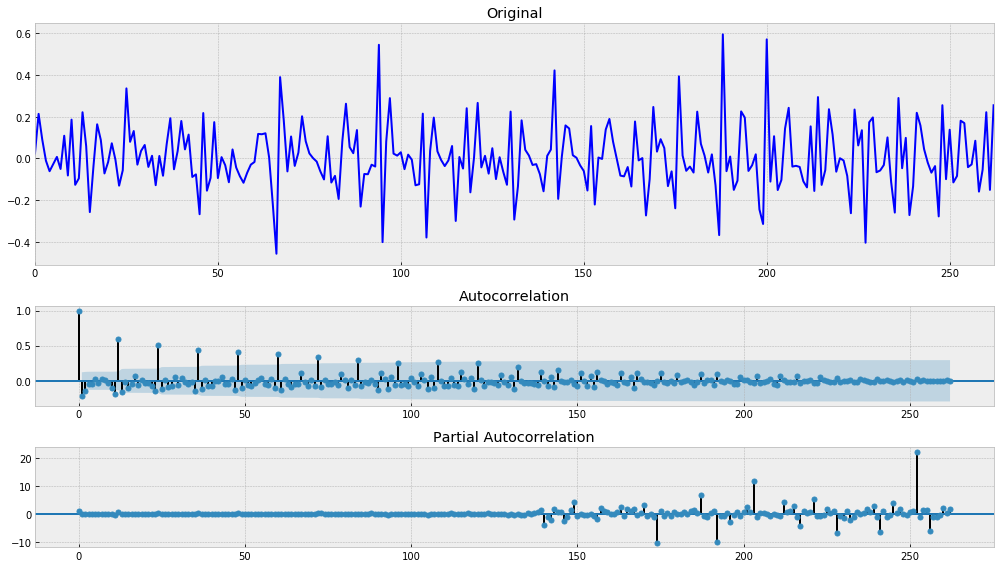

In [39]:
diff1_auto_series = np.diff(boxcox_auto_series, 1)
tsplot(diff1_auto_series)

Results of Dickey-Fuller Test:
Test Statistic                -1.075967e+01
p-value                        2.539779e-19
#Lags Used                     1.200000e+01
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


/mnt/c/linux-venv/nlp/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


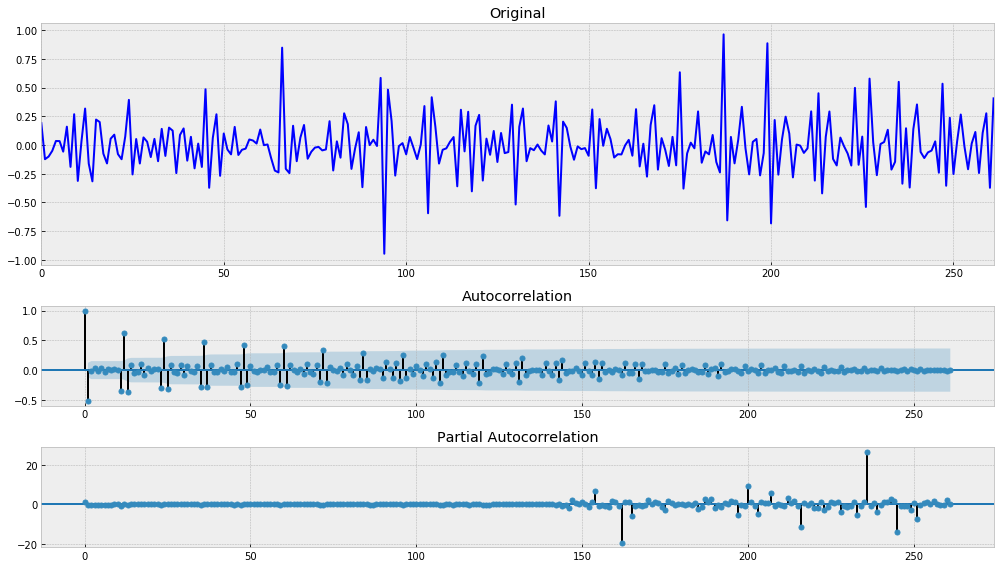

In [40]:
diff2_auto_series = np.diff(boxcox_auto_series, 2)
tsplot(diff2_auto_series)

Двойное дифференцирование дает лучший результат, чем одинарное. Но и одного дифференцирования хватает для получения требуемого значения p-value. Но коррелограммы не позволяют сделать однозначный вывод о стационарности ряда. Для дальнейшей работы возьмем одинарное дифференцирование, дабы избежать "переобучения"

Пробуем избавиться от сезонности.

Results of Dickey-Fuller Test:
Test Statistic                -6.528275e+00
p-value                        1.001817e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


/mnt/c/linux-venv/nlp/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


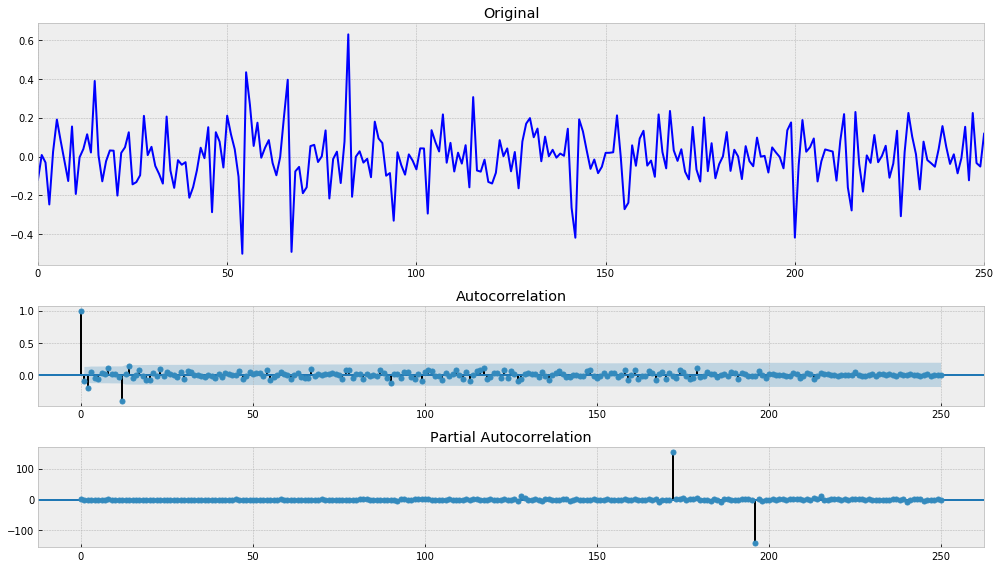

In [47]:
no_season_auto = diff1_auto_series[12:] - diff1_auto_series[:-12]
tsplot(no_season_auto)

После ликвидации сезонности значение p-value теста Дики-Фуллера улучшилось, коррелограммы выглядят гораздо лучше. Можем смело отринуть гипотезу о нестационарности ряда и признать ряд стационарным.